# Modèle DL pour classification (RNN et LSTM)

## Préparations des données

### Chargement des données

In [1]:
import numpy as np
import pandas as pd

def import_data():
    x_train = pd.read_csv(r"Dataset\AG_classif\x_train.csv", index_col=False)
    y_train = pd.read_csv(r"Dataset\AG_classif\y_train.csv", index_col=False)
    x_test = pd.read_csv(r"Dataset\AG_classif\x_test.csv", index_col=False)
    y_test = pd.read_csv(r"Dataset\AG_classif\y_test.csv", index_col=False)

    x_train = x_train['0']
    y_train = y_train['Class Index']
    x_test = x_test['0']
    y_test = y_test['Class Index']

    print("Taille du dataset d'entraînement :", x_train.shape[0])
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = import_data()

# Fusion des ensembles d'entraînement et de test
x = pd.concat([x_train, x_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)


Taille du dataset d'entraînement : 102080


### Tokénisation

In [2]:
import pickle
from nltk.tokenize import TreebankWordTokenizer

x = x.tolist()

x2 = [i.split() for i in x]

word_tokenizer = TreebankWordTokenizer()
tokens = [word_tokenizer.tokenize(sent) for sent in x]

print(len(tokens))
print(x2[0])
print(tokens[0])

127600
['mediation', 'resolve', 'dispute', 'fiat', 'general', 'corp', 'fiat', 'spa', 'meet', 'next', 'four', 'try', 'resolve', 'dispute', 'whether', 'fiat', 'force', 'buy', 'ail', 'fiat', 'auto', 'subsidiary']
['mediation', 'resolve', 'dispute', 'fiat', 'general', 'corp', 'fiat', 'spa', 'meet', 'next', 'four', 'try', 'resolve', 'dispute', 'whether', 'fiat', 'force', 'buy', 'ail', 'fiat', 'auto', 'subsidiary']


On remarque que le preprocessing à permit de faciliter la tokénisation car il suffit de faire .split() pour obtenir un dataset tokénisé

### Embedding

#### Création du modèle d'embedding 

In [3]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=tokens, vector_size=200, window=5, min_count=1, workers=4,epochs=10)
word2vec.save(r"Model/Classification/Général/word2vec.model")

#### Vectorisation et padding

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def vectorization(tokenized_sentences, word2vec_model):
    padded_sequences = []

    for tokens in tokenized_sentences:
        vecs = []
        for word in tokens:
            if word in word2vec_model.wv:
                vecs.append(word2vec_model.wv[word])
            else:
                vecs.append(np.zeros(word2vec_model.vector_size))
        padded_sequences.append(vecs)
    max_len = 200
    padded = pad_sequences(padded_sequences, maxlen=max_len ,padding='post', dtype='float32')
    return padded, max_len


x_padded, max_len = vectorization(tokens, word2vec)


### Split train & test

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.2, random_state=42)

Nécessaire de mettre -1 car Sparsecross entropy démarre a 0 et non à 1

In [6]:
y_train = y_train-1
y_test = y_test-1

## Préparation du model

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

num_classes = len(np.unique(y))  # nombre de classes

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, word2vec.vector_size)))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # nombre correct de classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)



c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrainnement du model

In [8]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 394s 122ms/step - accuracy: 0.8453 - loss: 0.4476 - val_accuracy: 0.8696 - val_loss: 0.3811
Epoch 2/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 287s 90ms/step - accuracy: 0.8823 - loss: 0.3378 - val_accuracy: 0.8746 - val_loss: 0.3615
Epoch 3/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 285s 89ms/step - accuracy: 0.8979 - loss: 0.2884 - val_accuracy: 0.8757 - val_loss: 0.3591
Epoch 4/10
3190/3190 ━━━━━━━━━━━━━━━━━━━━ 286s 90ms/step - accuracy: 0.9124 - loss: 0.2419 - val_accuracy: 0.8755 - val_loss: 0.3752


## Evaluation du model

#### Metric durant entrainnement

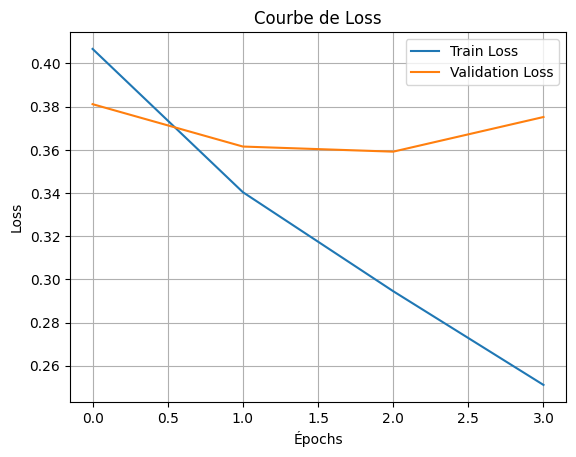

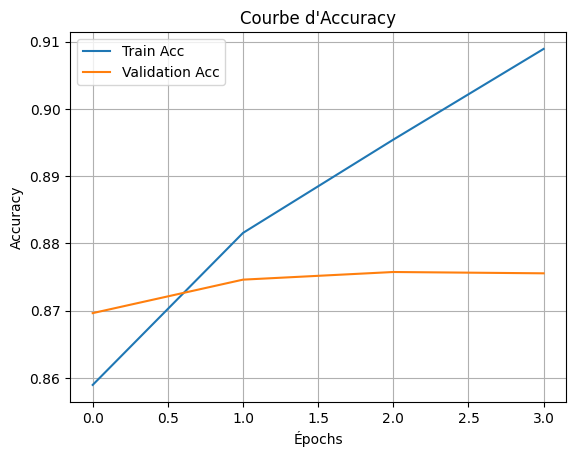

In [13]:
import matplotlib.pyplot as plt

# Affichage de la loss
def graph_loss(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Courbe de Loss")
    plt.xlabel("Épochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    return None

# Affichage de l'accuracy (ou autre métrique selon ton cas)
def graph_accuracy(history):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Validation Acc')
    plt.legend()
    plt.title("Courbe d'Accuracy")
    plt.xlabel("Épochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()
    return None

graph_loss(history)
graph_accuracy(history)

#### Matrice de confusion

In [14]:
print(x_test.shape)
print(y_test.shape)

(25520, 200, 200)
(25520,)


798/798 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      6325
           1       0.92      0.97      0.94      6435
           2       0.85      0.83      0.84      6471
           3       0.84      0.85      0.85      6289

    accuracy                           0.88     25520
   macro avg       0.88      0.88      0.88     25520
weighted avg       0.88      0.88      0.88     25520



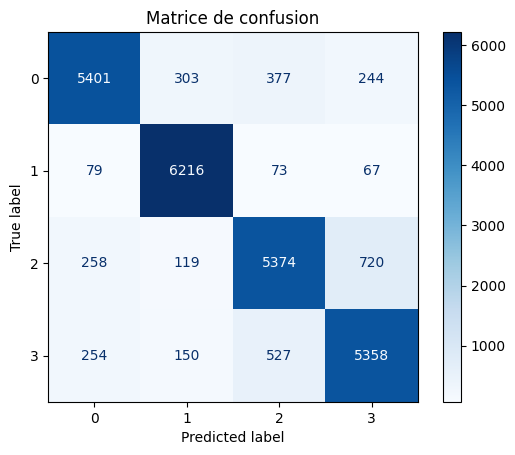

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def show_confusion_matrix(x_test, y_test, model):
    y_pred = model.predict(x_test)
    y_pred_classes = y_pred.argmax(axis=1)

    print(classification_report(y_test, y_pred_classes))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Matrice de confusion")
    plt.show()

# Utilisation
show_confusion_matrix(x_test, y_test, model)


#### Sauvegarder le model

In [17]:
model.save(r"Model/Classification/Général/model_dl.keras")